引入matplot以及numpy作為繪圖與數學運算

In [1]:
import wave
import matplotlib.pyplot as plt
import numpy as np
import math


引入librosa作為音訊處理的工具
並且引入IPython以在Jupyter notebook平台輸出聲音試驗

In [2]:
import librosa
import librosa.display
import IPython.display as ipd

wave, fs = librosa.load('sample.wav')

測試聲音是否正確

In [3]:
ipd.Audio('sample.wav') # load a local WAV file

匯出基本的waveform

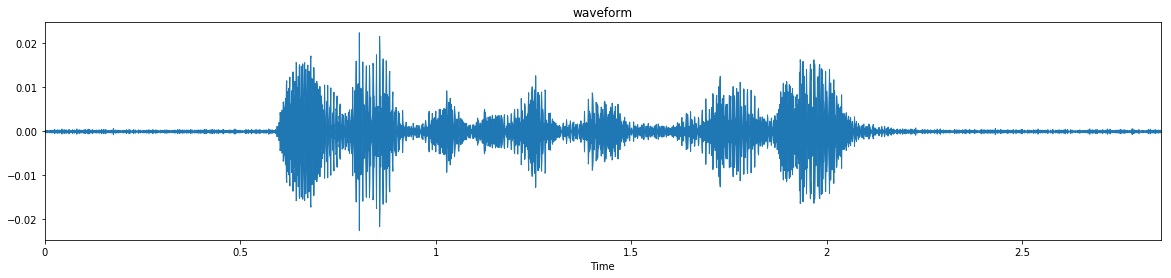

In [4]:
# t = np.arange(0, len(wave))/framerate
# plt.figure()
# plt.title('Audio wave')
# plt.plot(t, wave)
# plt.xlabel('time/sec')
# plt.show()

plt.figure(figsize=(20, 4))
librosa.display.waveplot(wave, sr=fs)
plt.title('waveform')
plt.show()


定義過零率函數和幀大小，繪製出過零率圖表

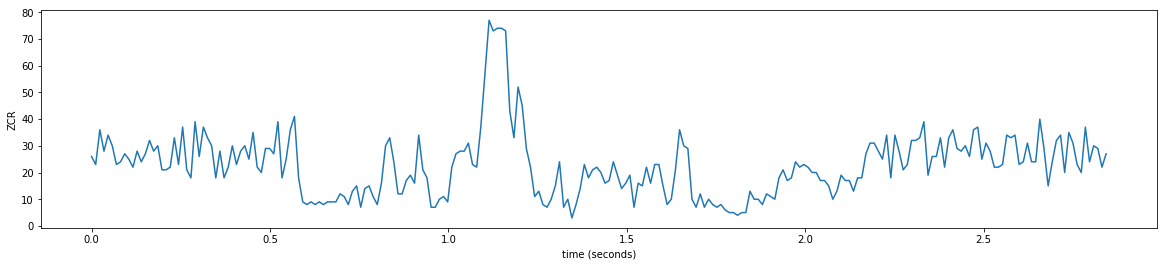

In [5]:
def zcr_cal(waveData,frameSize,overLap):
    wlen = len(waveData)
    step = frameSize - overLap
    frameNum = math.ceil(wlen/step)
    zcr = np.zeros((frameNum,1))
    for i in range(frameNum):
        curFrame = waveData[np.arange(i*step,min(i*step+frameSize,wlen))]
        zcr[i] = sum(curFrame[0:-1]*curFrame[1::]<=0)
    return zcr

frameSize = 256
overLap = 0
zcr = zcr_cal(wave,frameSize,overLap)

# print(len(zcr))
time_zcr = np.arange(0, len(zcr)) * (len(wave)/len(zcr) / fs)
plt.figure(figsize=(20, 4))
plt.plot(time_zcr, zcr)
plt.ylabel("ZCR")
plt.xlabel("time (seconds)")
plt.show()

使用short-time energy作為energy圖表的計算方式，並定義其函數以繪製

In [6]:
def ste_cal(waveData,frameSize, overLap):
    wlen = len(waveData)
    step = frameSize - overLap
    frameNum = math.ceil(wlen/step)
    en = np.zeros((frameNum,1))
    for i in range(frameNum):
        curFrame = waveData[np.arange(i*step,min(i*step+frameSize,wlen))]
        en[i] = sum(curFrame[0:-1]*curFrame[1::])
    return en

ste = ste_cal(wave,frameSize,overLap)

# print(len(zcr))
time_ste = np.arange(0, len(ste)) * (len(wave)/len(ste) / fs)
plt.figure(figsize=(20, 4))
plt.plot(time_ste,ste)
plt.xlabel("Time(s)")
plt.ylabel("Energy")
plt.title("Single channel Energy Contour")
plt.grid('on')

使用librosa內建的函式驗算過零率（zrc）和能量（root-mean square energy）圖表的正確性

In [7]:
frame_len = int(20 * fs /1000) # 20ms
frame_shift = int(10 * fs /1000) # 10ms
# calculate RMS
rms = librosa.feature.rmse(wave, frame_length=frame_len, hop_length=frame_shift)
rms = rms[0]
rms = librosa.util.normalize(rms, axis=0)

# calculate zero-crossing rate
zrc = librosa.feature.zero_crossing_rate(wave, frame_length=frame_len, hop_length=frame_shift, threshold=0)
zrc = zrc[0]
# zrc = librosa.util.normalize(zrc, axis=0)

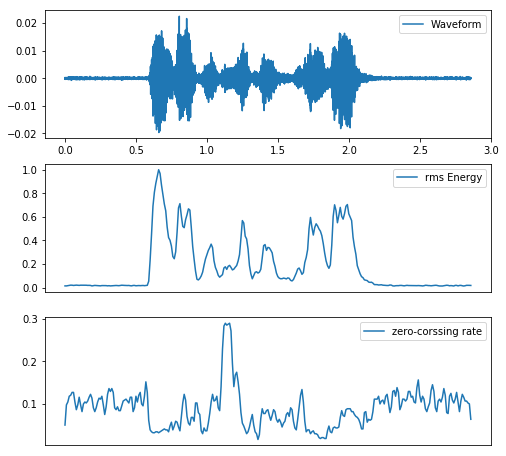

In [8]:
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
t = np.linspace(0, len(wave)/fs, len(wave))
plt.plot(t, wave, label='Waveform')
plt.legend(loc='best')

plt.subplot(3, 1, 2)
plt.plot(rms.T, label='rms Energy')
plt.xticks([])
plt.legend(loc='best')

plt.subplot(3, 1, 3)
plt.plot(zrc.T, label='zero-corssing rate')
plt.xticks([])
plt.legend(loc='best')
plt.show()

使用最大瞬間頻率來推測音高，並利用卷積平滑化圖表曲線

In [9]:
frame_len = int(25 * fs /1000) # 20ms
frame_shift = int(10 * fs /1000) # 10ms
frames = librosa.util.frame(wave, frame_length=frame_len, hop_length=frame_shift)

pitches, magnitudes = librosa.core.piptrack(wave, sr=fs, hop_length=frame_shift, threshold=0.75)

In [10]:
def extract_max(pitches, shape):
    new_pitches = []
    for i in range(0, shape[1]):
        new_pitches.append(np.max(pitches[:,i]))
    return new_pitches

def smooth(x,window_len=11,window='hanning'):
        if window_len<3:
                return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
                raise(ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
        s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
                w=np.ones(window_len,'d')
        else:
                w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]

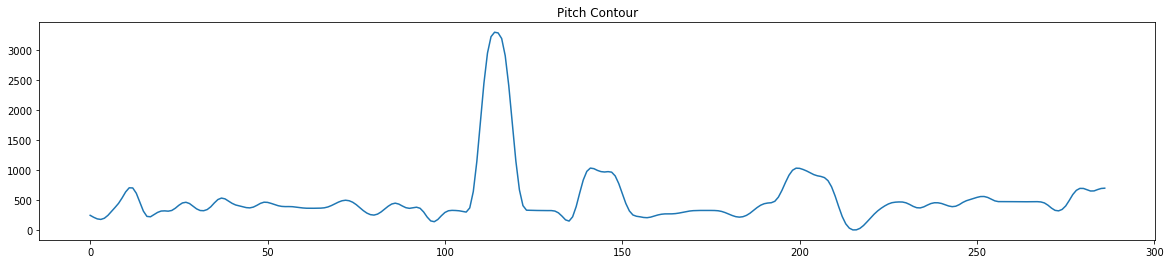

In [11]:
pitch_track = extract_max(pitches, pitches.shape)
pitch_smoothtrack = smooth(pitch_track, window_len=10)
plt.figure(figsize=(20, 4))
plt.plot(pitch_smoothtrack)
plt.title("Pitch Contour")
plt.show()

和waveform做比較

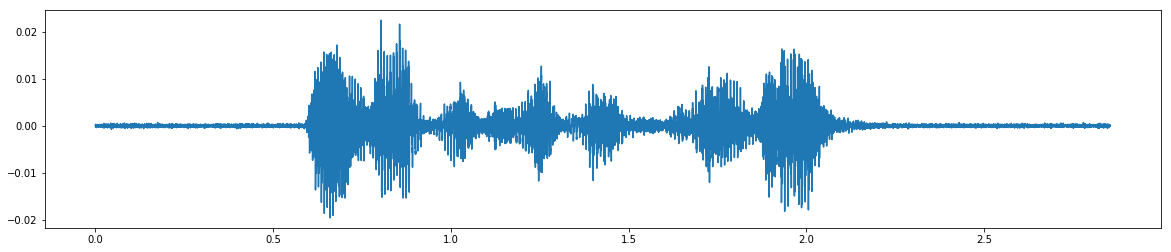

In [12]:
plt.figure(figsize=(20, 4))
plt.plot(t, wave)
plt.show()

根據計算出的界線值來預測一個字的起點和結束
在此以綠色代表起點，紅色代表結束

In [13]:
frame_idxs = np.where( (rms > 0.3) | (zrc > 0.5) )[0]
def getboundaries(frame_idxs):
    start_idxs = [frame_idxs[0]]
    end_idxs = []

    shapeofidxs = np.shape(frame_idxs)
    for i in range(shapeofidxs[0]-1):
        if (frame_idxs[i + 1] - frame_idxs[i]) != 1:
            end_idxs.append(frame_idxs[i])
            start_idxs.append(frame_idxs[i+1])

    end_idxs.append(frame_idxs[-1])
    # del the last boundaries if it is both start point and end point.
    if end_idxs[-1] == start_idxs[-1]:
        end_idxs.pop()
        start_idxs.pop()
    assert len(start_idxs) == len(end_idxs), 'Error! Num of start_idxs doesnt match Num of end_idxs.'
    start_idxs = np.array(start_idxs)
    end_idxs = np.array(end_idxs)
    start_t = start_idxs * frame_shift / fs
    end_t = end_idxs * frame_shift / fs
    return start_t, end_t


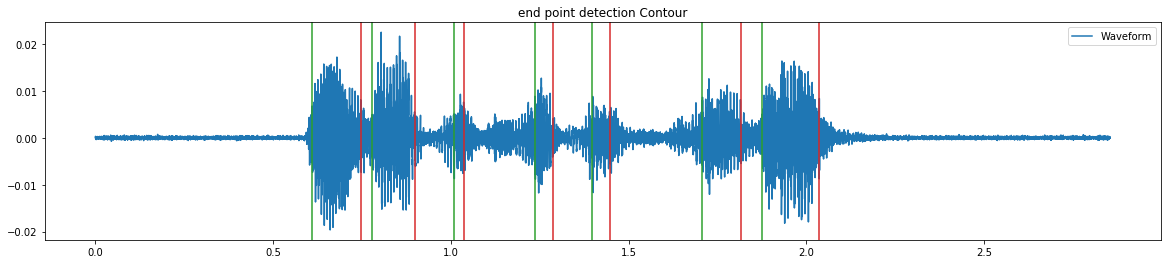

In [14]:
start_t, end_t = getboundaries(frame_idxs)


plt.figure(figsize=(20, 4))
t = np.linspace(0, len(wave)/fs, len(wave))
plt.plot(t, wave, label='Waveform')
for s, e in zip(start_t, end_t):
    plt.axvline(x=s, color='#2ca02c') 
    plt.axvline(x=e, color='#d62728')
plt.legend(loc='best')
plt.title("end point detection Contour")
plt.show()

可以看出，其大致可以辨識出「多媒體系統與應用」等八個字